# Курсовой проект - Урок 5. Face Detection and Emotion Recognition

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре (по согласованию с преподавателем этот пункт можно не делать). После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

In [2]:
import PIL

## Часть 1. Подготовка данных

1. Создадим объекты для необходимых трансформаций нашего датасета:

In [3]:
# Картинки чернобелые   
# Настройки для расширения датасета
# Случайные повороты на 90 градусов
# Случайные повороты на 30 градусов
# Приведение к тензору
#train_transforms = tt.Compose([tt.Resize((48,128),interpolation=PIL.Image.NEAREST),tt.Grayscale(num_output_channels=1),tt.RandomHorizontalFlip(),tt.RandomRotation(30),tt.ToTensor()])
train_transforms = tt.Compose([tt.Resize((48,128)),tt.Grayscale(num_output_channels=1),tt.RandomHorizontalFlip(),tt.RandomRotation(30),tt.ToTensor()])

#test_transforms = tt.Compose([tt.Resize((48,128),interpolation=PIL.Image.NEAREST),tt.Grayscale(num_output_channels=1), tt.ToTensor()])
test_transforms = tt.Compose([tt.Resize((48,128)),tt.Grayscale(num_output_channels=1), tt.ToTensor()])

2. Для обучения нейронной сети будем использовать этот датасет  https://www.kaggle.com/gti-upm/leapgestrecog.
Загрузим его и распакуем содержимое в папку leapGestRecog.

In [4]:
data_dir = './leapGestRecog'
print(os.listdir(data_dir))

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 'leapGestRecog', 'test', 'train']


В каждой такой папке (т.е. субъекте, который показывал жесты) у нас набор классов определенных жестов - 10 классов жестов для каждого субъекта. Мы создаем 2 папки - test и train куда соответственно помещаем все папки для всех субъектов в такой пропорции - с 0 по 7 субъект (содержимое папок 00,...07) или 80% данных перемещаем в папку train - на них мы будем обучать систему, а 20% данных с 8 по 9 субъект (содержимое папок 08,09) перемещаем в папку test.

In [5]:
classes_train = os.listdir(data_dir + "/train")
classes_test = os.listdir(data_dir + "/test")
print(f'Train Classes - {classes_train}')
print(f'test Classes - {classes_test}')

Train Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
test Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


Напишем словарь для сопоставления выхода с нейронной сети с названием жестов:

In [6]:
digit_to_classname = {0:'01_palm', 1:'02_l', 2:'03_fist', 3:'04_fist_moved', 4:'05_thumb', 5:'06_index', 6:'07_ok', 7:'08_palm_moved', 8:'09_c', 9:'10_down'}

In [7]:
train_dataset = ImageFolder(data_dir + '/train', train_transforms)
test_dataset  = ImageFolder(data_dir + '/test', test_transforms)

In [8]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 16000
    Root location: ./leapGestRecog/train
    StandardTransform
Transform: Compose(
               Resize(size=(48, 128), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               ToTensor()
           )

In [9]:
#размер пакета
batch_size =20

3. Создадим наши даталоадеры:

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

Создадим функцию для просмотра случайных картинок из получившегося датасета:

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 128])


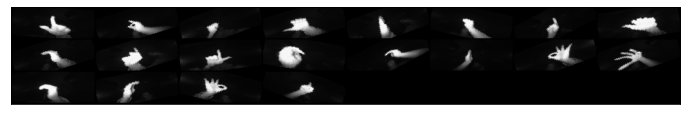

In [12]:
show_batch(train_dataloader)

In [13]:
len(train_dataloader)

800

4. Напишем функции для перевода наших моделей и Даталоадеров на необходимое оборудование:

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cpu')

In [16]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

## Часть 2. Создание модели

In [17]:


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.conv7 = self.conv_block(512, 1024)
        self.conv8 = self.conv_block(1024, 1024, pool=True)
        self.res4 = nn.Sequential(self.conv_block(1024, 1024), self.conv_block(1024, 1024))
        self.drop4 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3), 
                                        nn.Flatten(),
                                        nn.Linear(2048, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.res4(out) + out
        out = self.drop4(out)
        
        out = self.classifier(out)
        return out

In [18]:
model = to_device(ResNet(1, len(classes_train)), device)

In [19]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

## Часть 3. Обучение

In [20]:
# Если работаете на гпу, очищаем весь кэш
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()


epochs = 10 
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

In [21]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

10 epochs, 800 total_steps per epoch


In [22]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = Variable(data), Variable(labels)
        data = data.to(device)
        labels = labels.to(device)
        
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  1.5952174067497253
Epoch 2, loss:  0.8702891956170788
Epoch 3, loss:  0.39092102951777635
Epoch 4, loss:  0.33717548874905334
Epoch 5, loss:  0.33251897723646834
Epoch 6, loss:  0.2642938782315468
Epoch 7, loss:  0.20243687583249995
Epoch 8, loss:  0.1000041461836372
Epoch 9, loss:  0.03277051137949456
Epoch 10, loss:  0.011594804081141774


Посмотрим на нашу ошибку в процессе обучения:

Text(0.5, 1.0, 'losses vs. No. of epochs')

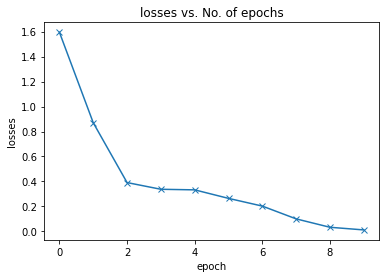

In [23]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

Сохраним нашу модель:

In [24]:
torch.save(model.state_dict(), 'leapGestRecog_model_state.pth')

## Часть 4. Результаты

Загрузим ее и будем использовать

In [22]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load('leapGestRecog_model_state.pth'))
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

Прогоним нашу нейронную сеть через тестовый датасет:

<ipython-input-23-52008b41c006>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)


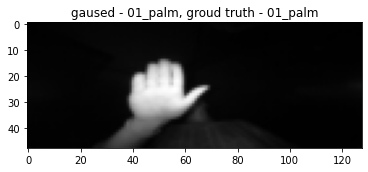

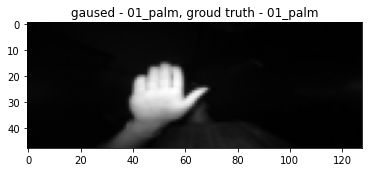

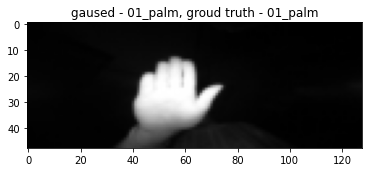

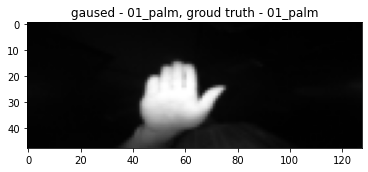

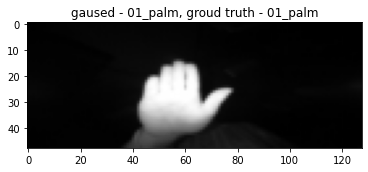

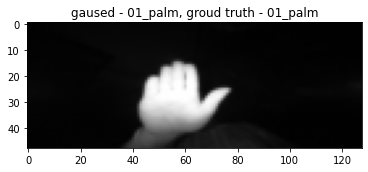

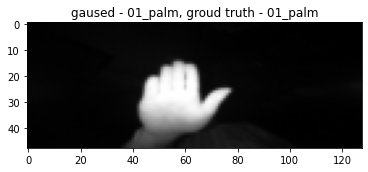

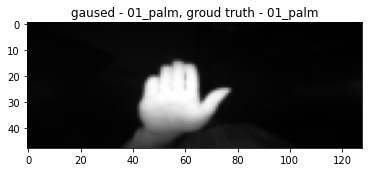

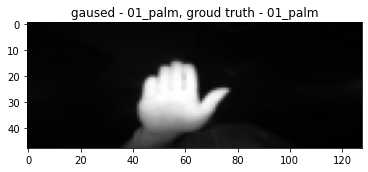

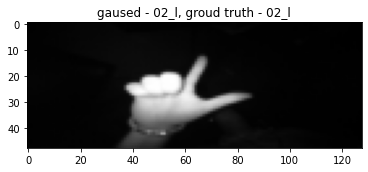

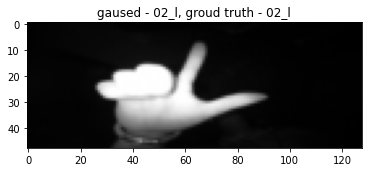

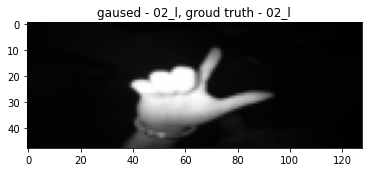

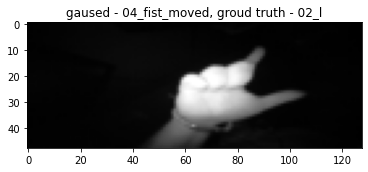

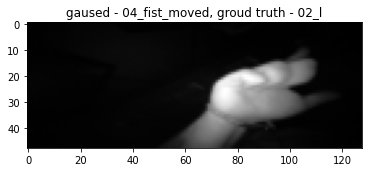

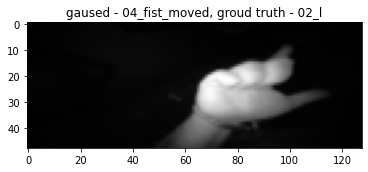

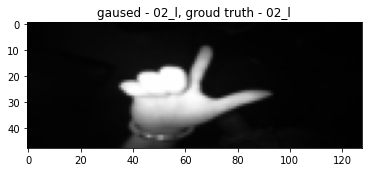

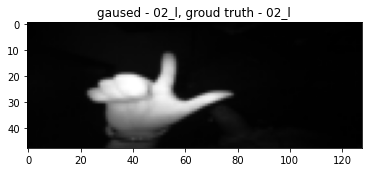

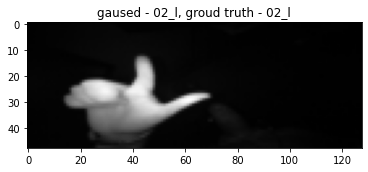

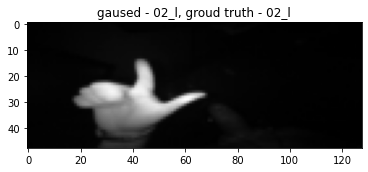

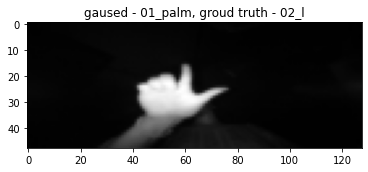

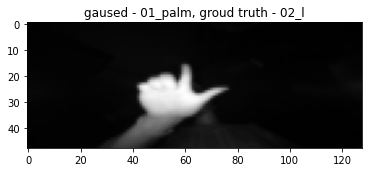

In [23]:
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        if i > 10:
            images, labels = data
            images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
            outputs = net(images)
       
            plt.title(f'gaused - {digit_to_classname[outputs[0].argmax().numpy().item(0)]}, groud truth - {digit_to_classname[labels[0].numpy().item(0)]}')
            plt.imshow(images[0].cpu().squeeze(), cmap='gray')
            plt.show()
        if i>30:
            break

Паплайн распознавания жестов с использованием веб камеры

In [26]:
!pip install facenet_pytorch

In [27]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

In [58]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

# Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
cap = cv2.VideoCapture(0)  

# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self):
       
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = ResNet(1, len(classes_train)).to(self.device)
        self.emodel.load_state_dict(torch.load('leapGestRecog_model_state.pth'))
        self.emodel.eval()

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, gesture):
        try:            
            org = (50, 50) 
                # пишем на кадре какой жест распознан
            cv2.putText(frame,
                        gesture, org, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            
            org = (50, 400)
            if gesture=='07_ok':
                cv2.putText(frame,
                            'Hello', org, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            if gesture=='10_down':
                cv2.putText(frame,
                            'Good bye', org, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            

        except:
            print('Something wrong im draw function!')

        return frame
    
    
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return '01_palm'
        elif digit == 1:
            return '02_l'
        elif digit == 2:
            return '03_fist'
        elif digit == 3:
            return '04_fist_moved'
        elif digit == 4:
            return '05_thumb'
        elif digit == 5:
            return '06_index'
        elif digit == 6:
            return '07_ok'
        elif digit == 7:
            return '08_palm_moved'
        elif digit == 8:
            return '09_c'
        elif digit == 9:
            return '10_down'
        
     # Функция для вырезания жеста с кадра
    @staticmethod
    def crop_gesture(frame, box):
        gesture = []       
        gesture.append(frame[int(box[1]):int(box[3]),
                             int(box[0]):int(box[2])])
        return gesture
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
              
                box=[10,10,200,200]
                # Вырезаем жест из кадра
                gesture_frame = self.crop_gesture(frame, box)[0]
                # Меняем размер изображения  для входа в нейронную сеть
                frame_processed = cv2.resize(gesture_frame,(48, 128))
                # Превращаем в 1-канальное серое изображение
                frame_processed = cv2.cvtColor(frame_processed, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку в pytorch-тензор
                torch_frame = torch.from_numpy(frame_processed).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор картинки или жеста в нейронную сеть и получаем предсказание
                gesture = self.emodel(torch_frame[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
                gesture = self.digit_to_classname(gesture.argmax())

                # Рисуем на кадре
                self._draw(frame, gesture)

            except Exception as e:
                print(e)
                #print('Something wrong im main cycle!')

            # Показываем кадр в окне, и назвываем его(окно) - 'Gest Detection'
            cv2.imshow('Gest Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
        


# Создаем объект нашего класса приложения
fcd = FaceDetector()
# Запускаем
fcd.run()